## 1. Import libraries

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

2. Data Preprocessing

In [2]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [3]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

100%|██████████| 149M/149M [00:02<00:00, 73.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [5]:
tr_df = train_df('/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training')

In [6]:
tr_df

,Class Path,Class
0,/root/.cache/kagglehub/datasets/masoudnickparv...,meningioma
1,/root/.cache/kagglehub/datasets/masoudnickparv...,meningioma
2,/root/.cache/kagglehub/datasets/masoudnickparv...,meningioma
3,/root/.cache/kagglehub/datasets/masoudnickparv...,meningioma
4,/root/.cache/kagglehub/datasets/masoudnickparv...,meningioma
...,...,...
5707,/root/.cache/kagglehub/datasets/masoudnickparv...,pituitary
5708,/root/.cache/kagglehub/datasets/masoudnickparv...,pituitary
5709,/root/.cache/kagglehub/datasets/masoudnickparv...,pituitary
5710,/root/.cache/kagglehub/datasets/masoudnickparv...,pituitary


In [7]:
ts_df = test_df('/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing')

In [8]:
ts_df

,Class Path,Class
0,/root/.cache/kagglehub/datasets/masoudnickparv...,meningioma
1,/root/.cache/kagglehub/datasets/masoudnickparv...,meningioma
2,/root/.cache/kagglehub/datasets/masoudnickparv...,meningioma
3,/root/.cache/kagglehub/datasets/masoudnickparv...,meningioma
4,/root/.cache/kagglehub/datasets/masoudnickparv...,meningioma
...,...,...
1306,/root/.cache/kagglehub/datasets/masoudnickparv...,pituitary
1307,/root/.cache/kagglehub/datasets/masoudnickparv...,pituitary
1308,/root/.cache/kagglehub/datasets/masoudnickparv...,pituitary
1309,/root/.cache/kagglehub/datasets/masoudnickparv...,pituitary


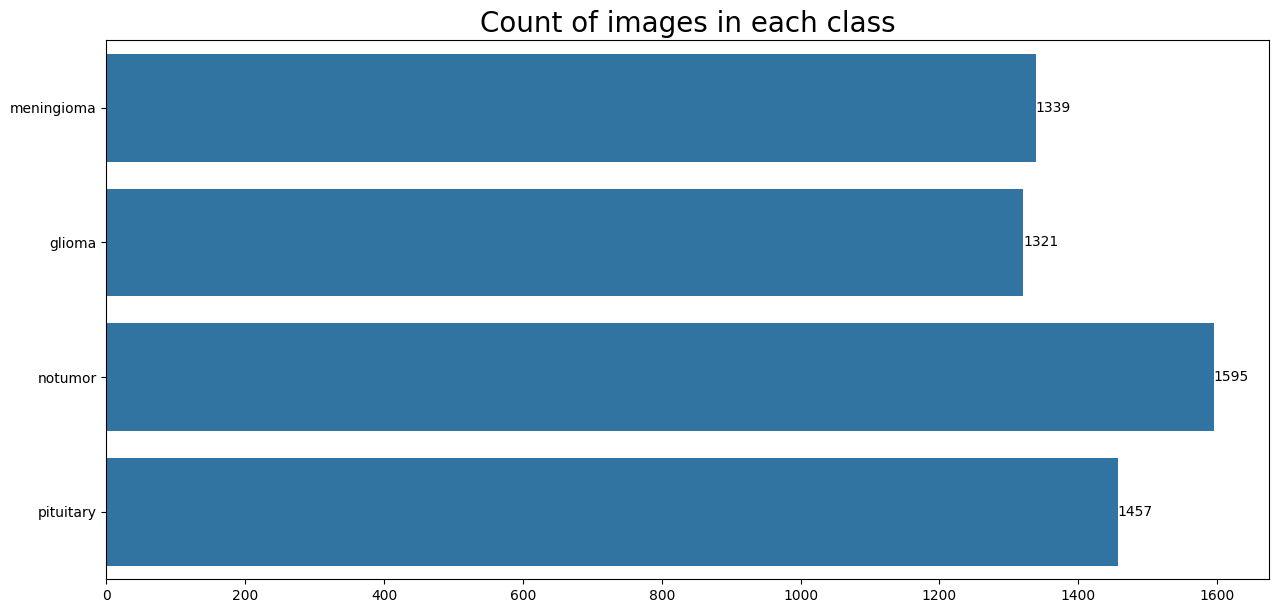

In [9]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

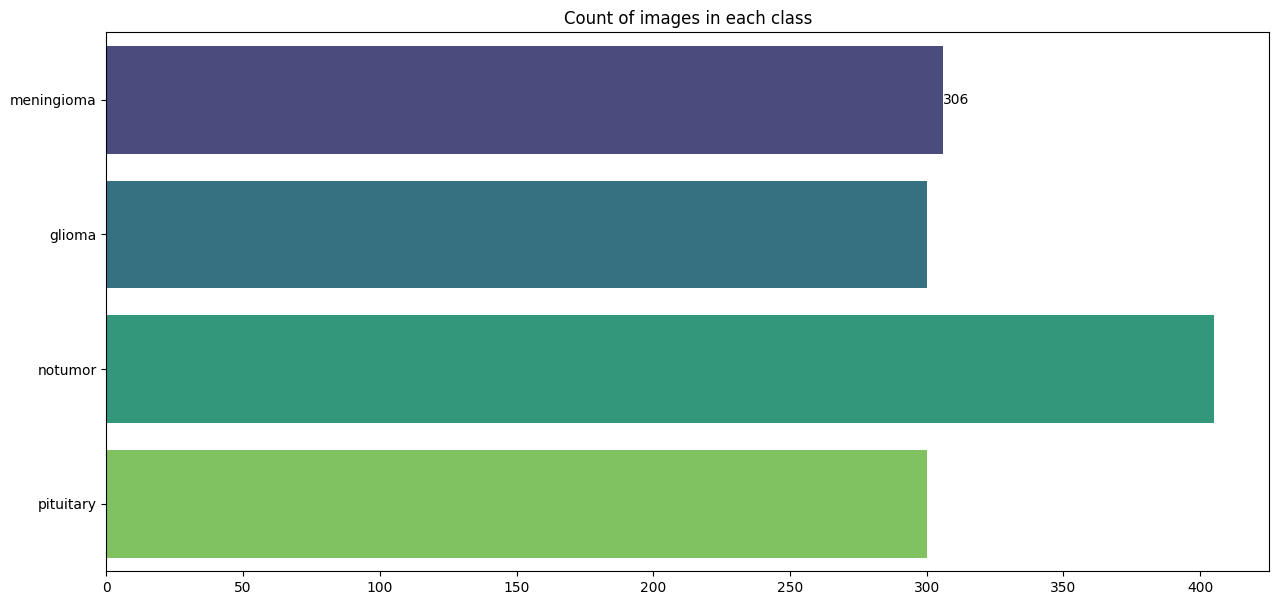

In [10]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

In [11]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [12]:
valid_df

,Class Path,Class
592,/root/.cache/kagglehub/datasets/masoudnickparv...,glioma
18,/root/.cache/kagglehub/datasets/masoudnickparv...,meningioma
1072,/root/.cache/kagglehub/datasets/masoudnickparv...,pituitary
73,/root/.cache/kagglehub/datasets/masoudnickparv...,meningioma
415,/root/.cache/kagglehub/datasets/masoudnickparv...,glioma
...,...,...
365,/root/.cache/kagglehub/datasets/masoudnickparv...,glioma
860,/root/.cache/kagglehub/datasets/masoudnickparv...,notumor
579,/root/.cache/kagglehub/datasets/masoudnickparv...,glioma
194,/root/.cache/kagglehub/datasets/masoudnickparv...,meningioma


In [13]:
batch_size = 32
img_size = (224, 224)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


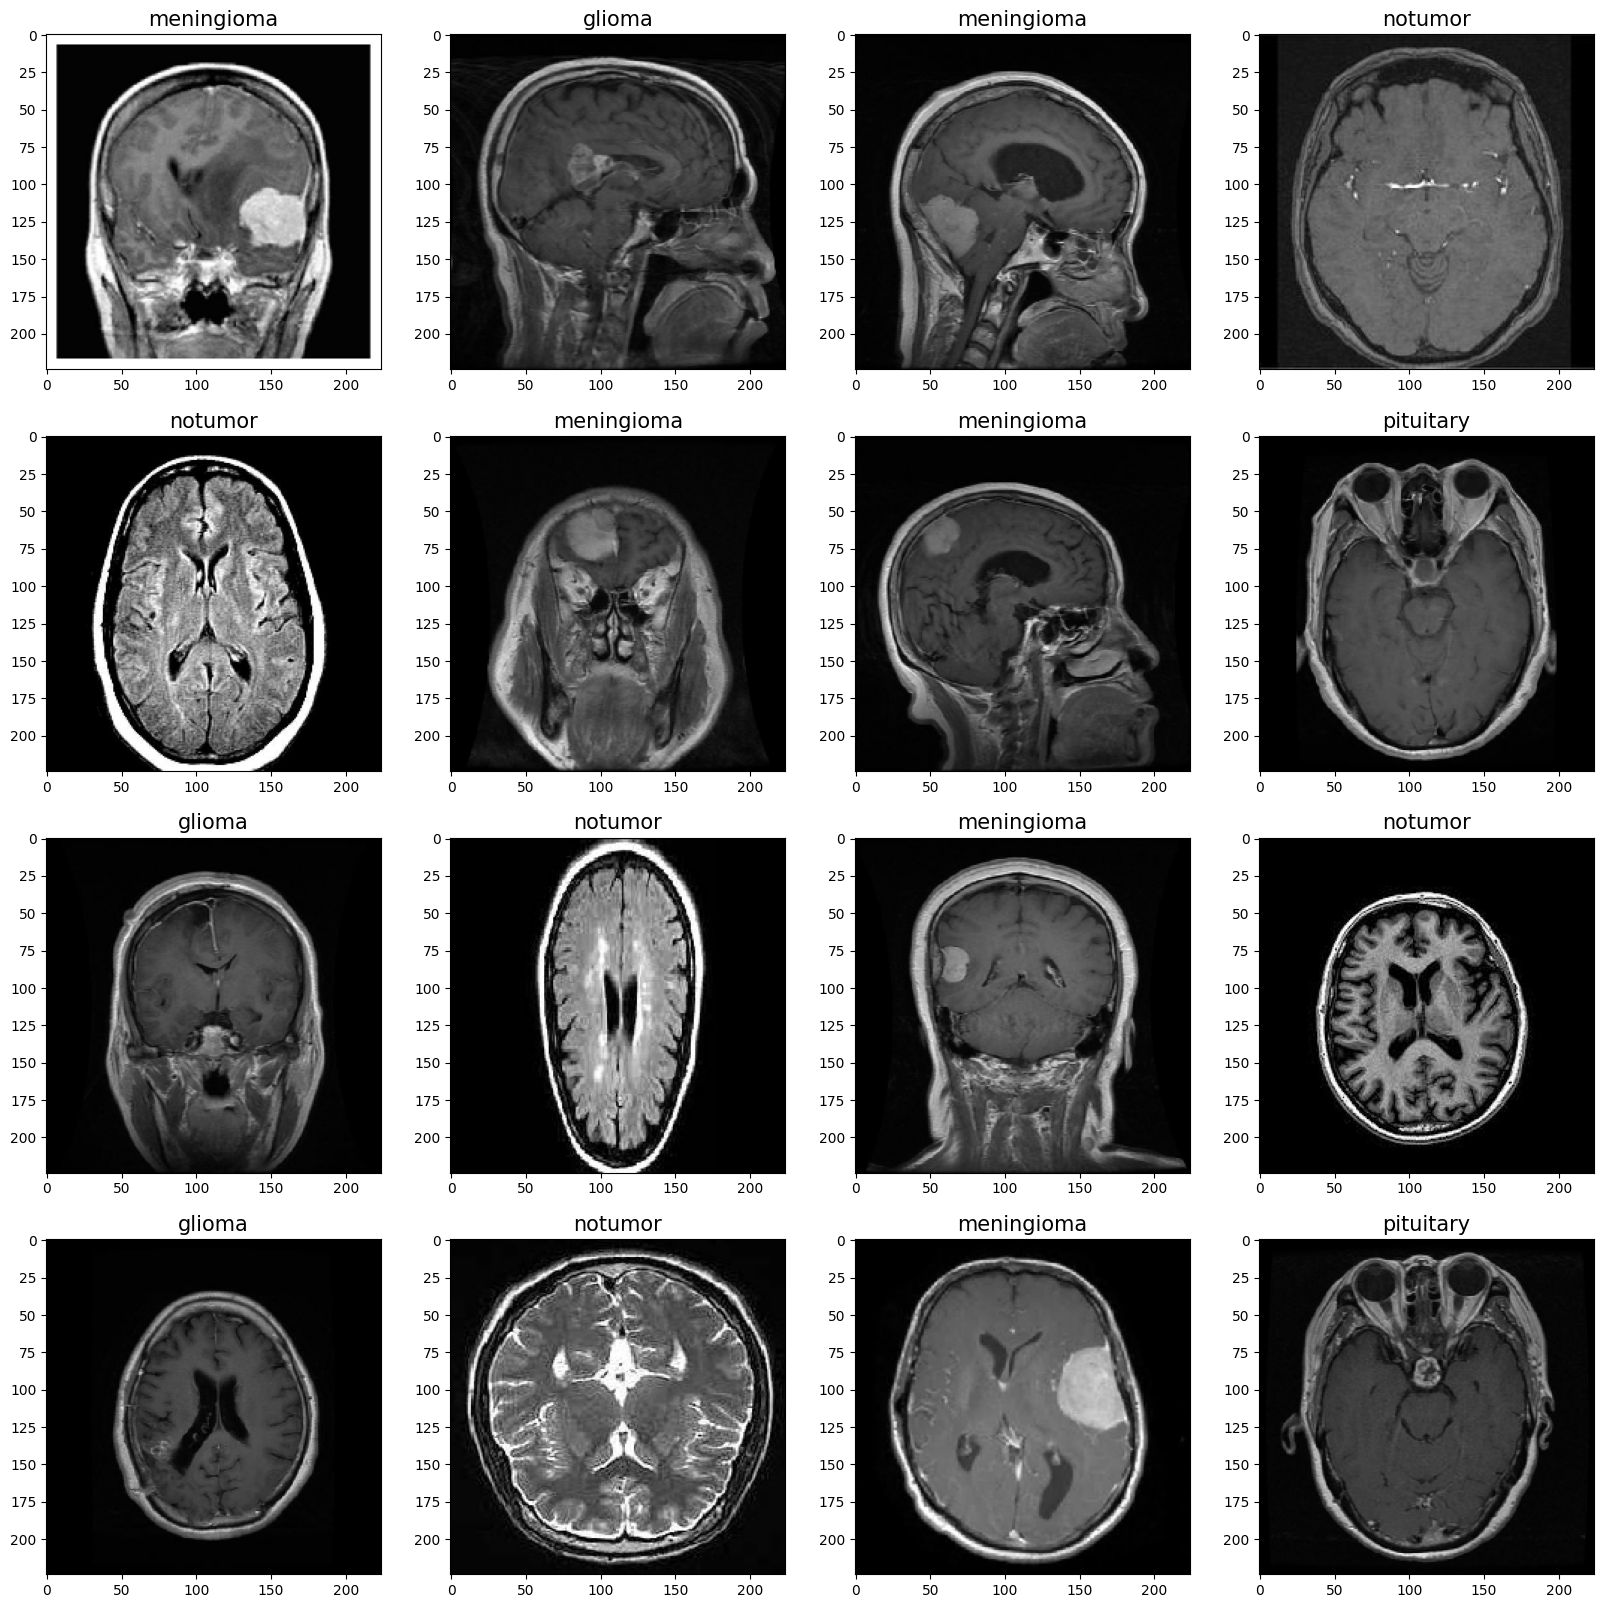

In [14]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

## 3. Building Deep Learning Model with DenseNet121

In [15]:
# Image shape for X-Ray data
img_shape = (224, 224, 3)

# Use DenseNet121 as the base model
base_model = tf.keras.applications.DenseNet121(
    include_top=False,  # Exclude the final fully connected layer
    weights="imagenet",  # Use ImageNet weights for Transfer Learning
    input_shape=img_shape,
    pooling="max"  # Global MaxPooling after the base model
)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the transfer learning model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),  # Regularization to prevent overfitting
    Dense(256, activation="relu"),  # Increased neurons for more representation power
    Dropout(rate=0.25),
    Dense(4, activation="softmax")  # Adjust output to match your number of classes
])

# Compile the model
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy", Precision(), Recall()]
)

# Display the model summary
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 1024)                │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 263,428 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

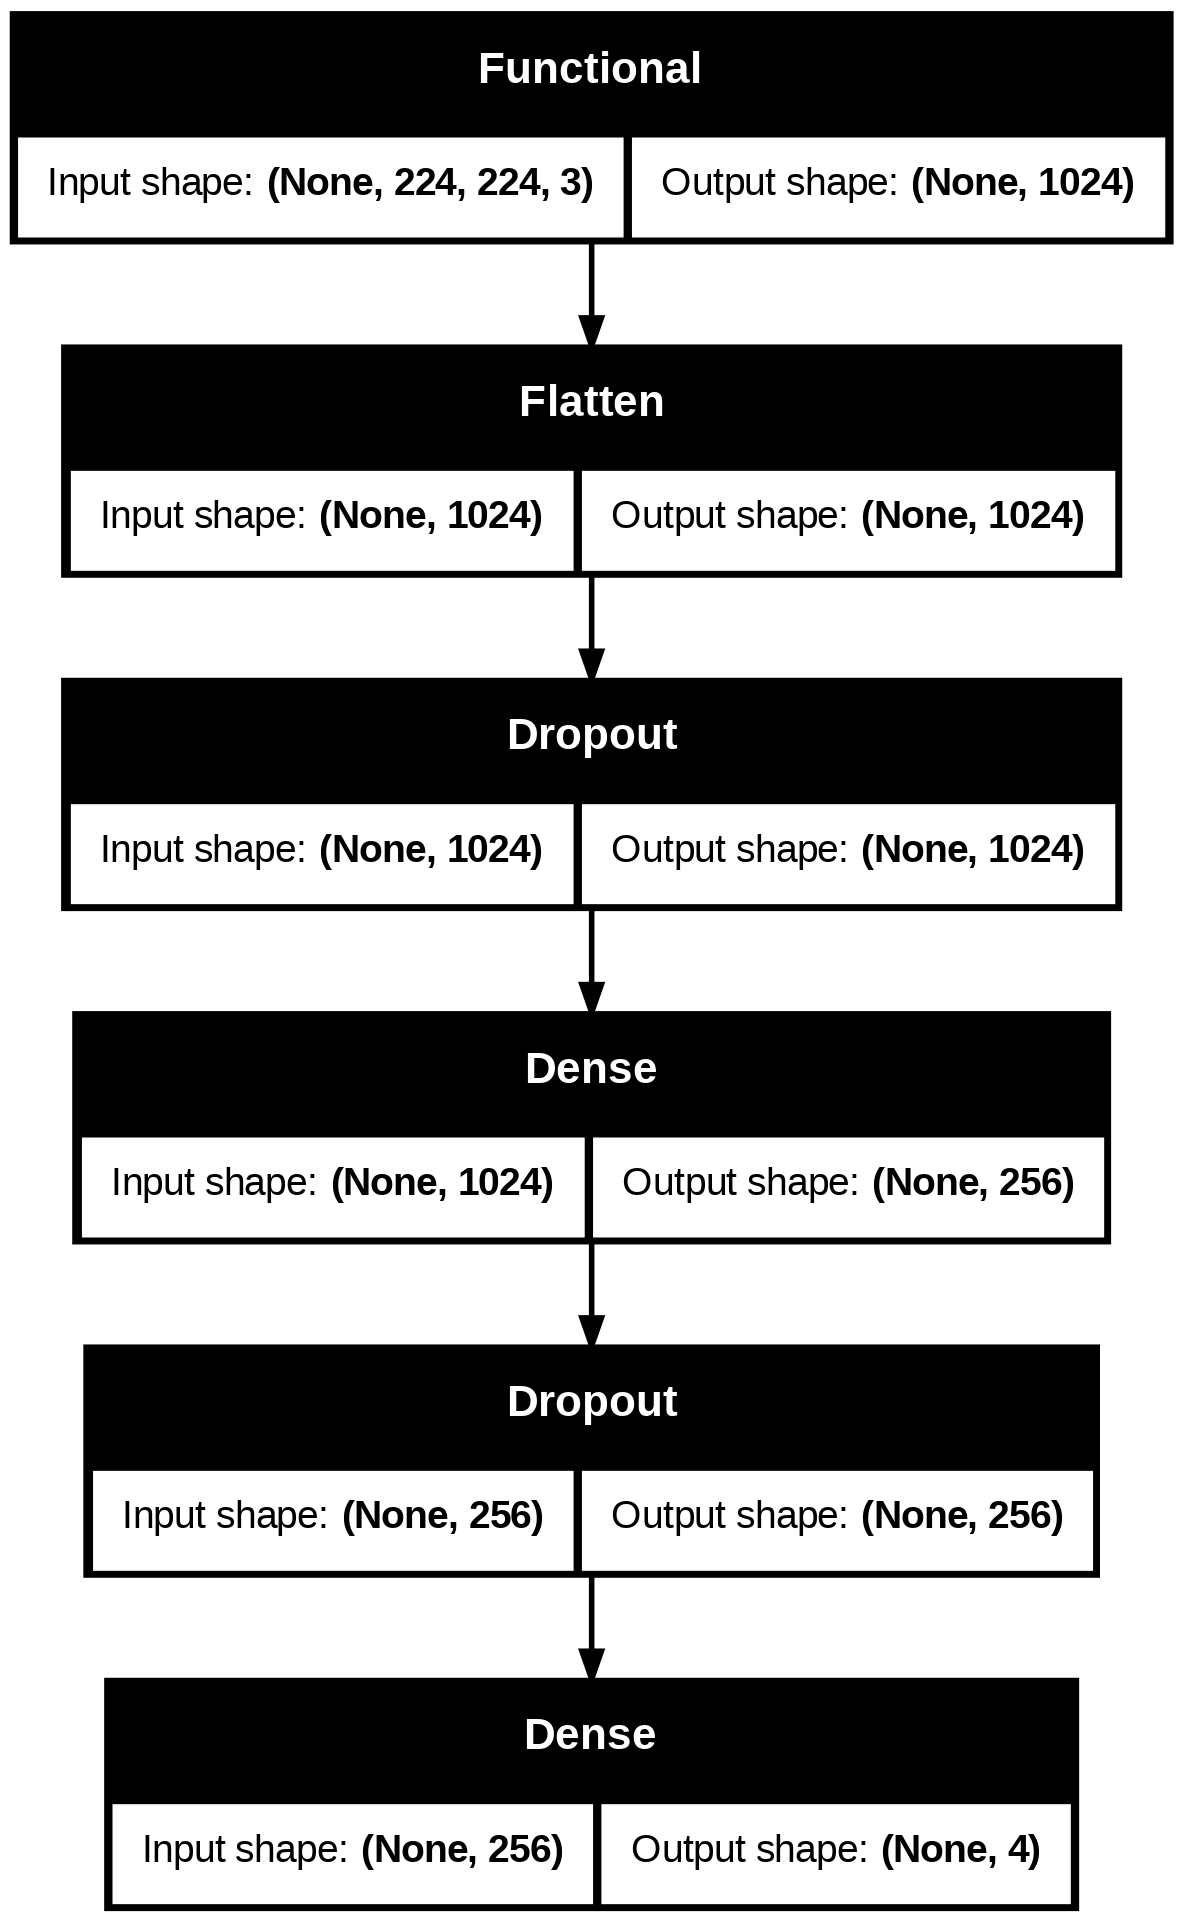

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

## 3. Training

In [17]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 84s 314ms/step - accuracy: 0.5154 - loss: 2.6582 - precision: 0.5265 - recall: 0.4990 - val_accuracy: 0.7786 - val_loss: 0.6038 - val_precision: 0.8190 - val_recall: 0.7389
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 25s 139ms/step - accuracy: 0.7100 - loss: 0.7781 - precision: 0.7476 - recall: 0.6749 - val_accuracy: 0.7969 - val_loss: 0.5652 - val_precision: 0.8362 - val_recall: 0.7481
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 145ms/step - accuracy: 0.7447 - loss: 0.6669 - precision: 0.7752 - recall: 0.7104 - val_accuracy: 0.8000 - val_loss: 0.5467 - val_precision: 0.8399 - val_recall: 0.7527
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 25s 139ms/step - accuracy: 0.7707 - loss: 0.5875 - precision: 0.8081 - recall: 0.7317 - val_accuracy: 0.8183 - val_loss: 0.4897 - val_precision: 0.8715 - val_recall: 0.7664
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 25s 141ms/step - accuracy: 0.7916 - loss: 0.5447 - precision: 0.8230 - recall: 0.7612 - val_accuracy: 0.7939

In [18]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

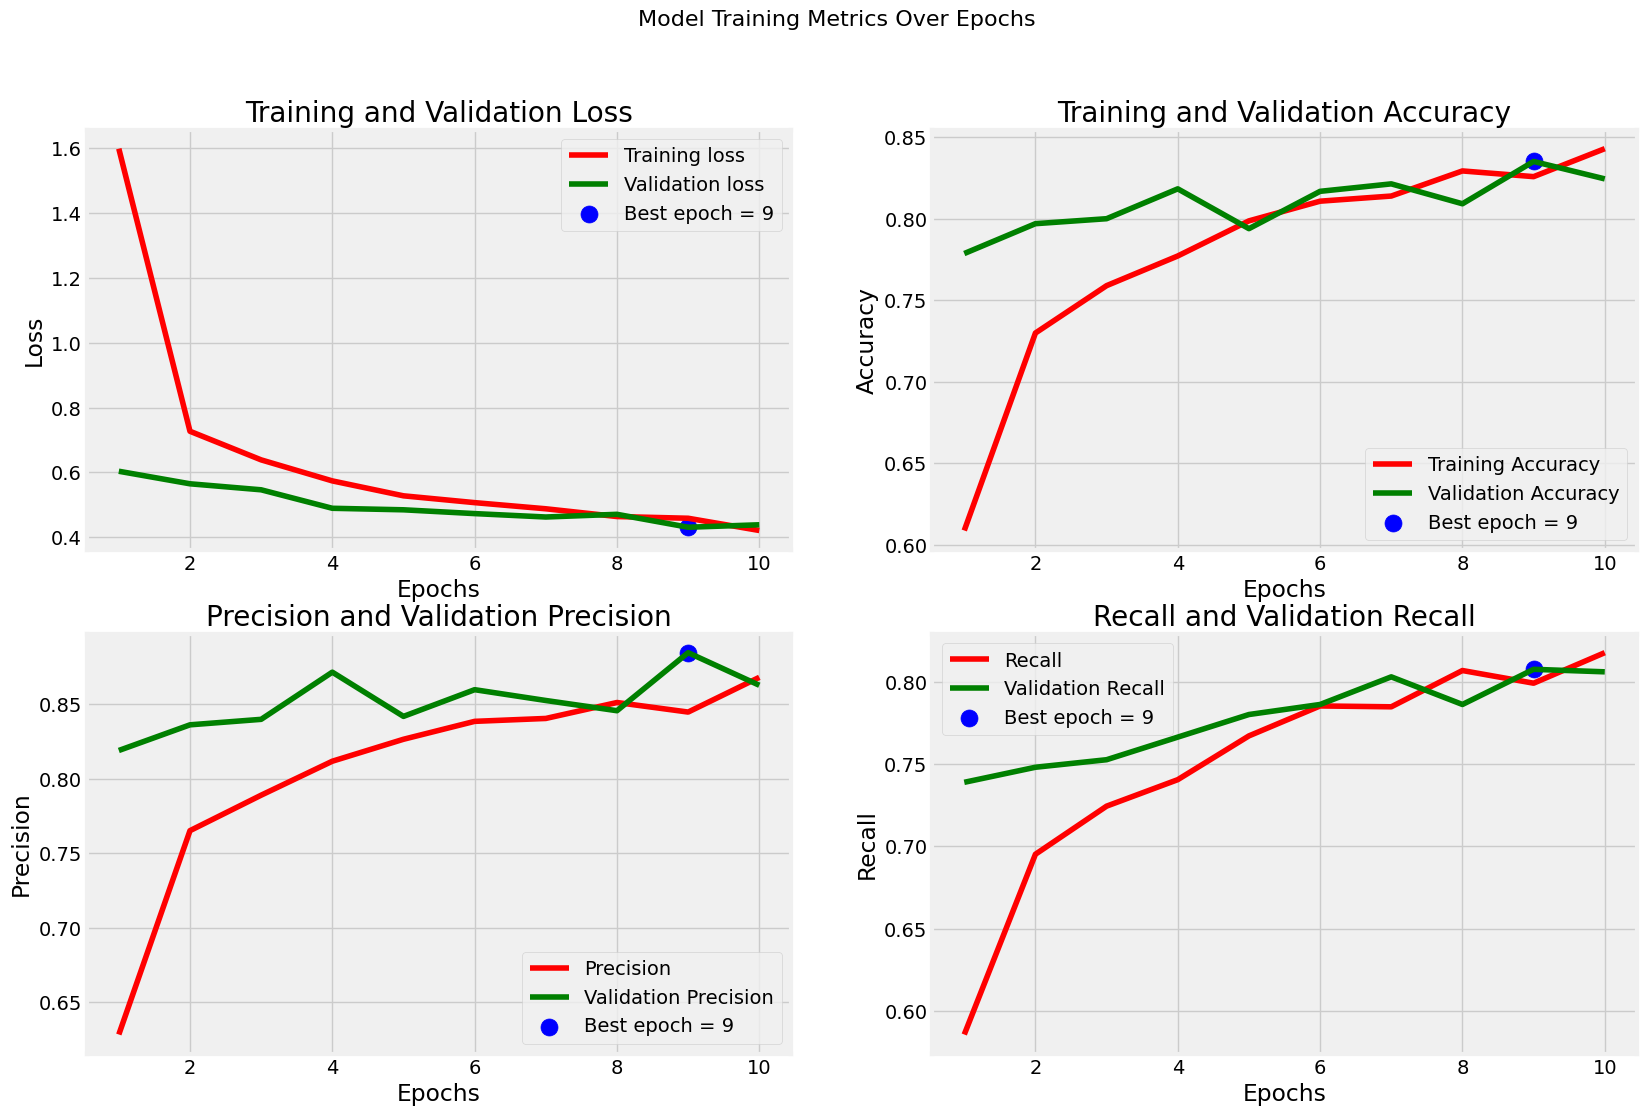

In [19]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

## 5. Evaluation

In [20]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 27s 151ms/step - accuracy: 0.8894 - loss: 0.2973 - precision: 0.9048 - recall: 0.8727
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.8461 - loss: 0.4244 - precision: 0.8773 - recall: 0.8252
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8277 - loss: 0.4393 - precision: 0.8448 - recall: 0.7882
Train Loss: 0.2984
Train Accuracy: 88.92%
--------------------
Validation Loss: 0.4371
Validation Accuracy: 83.05%
--------------------
Test Loss: 0.4169
Test Accuracy: 83.08%


In [ ]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

In [ ]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [ ]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

## 6. Testing

In [26]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((224, 224))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


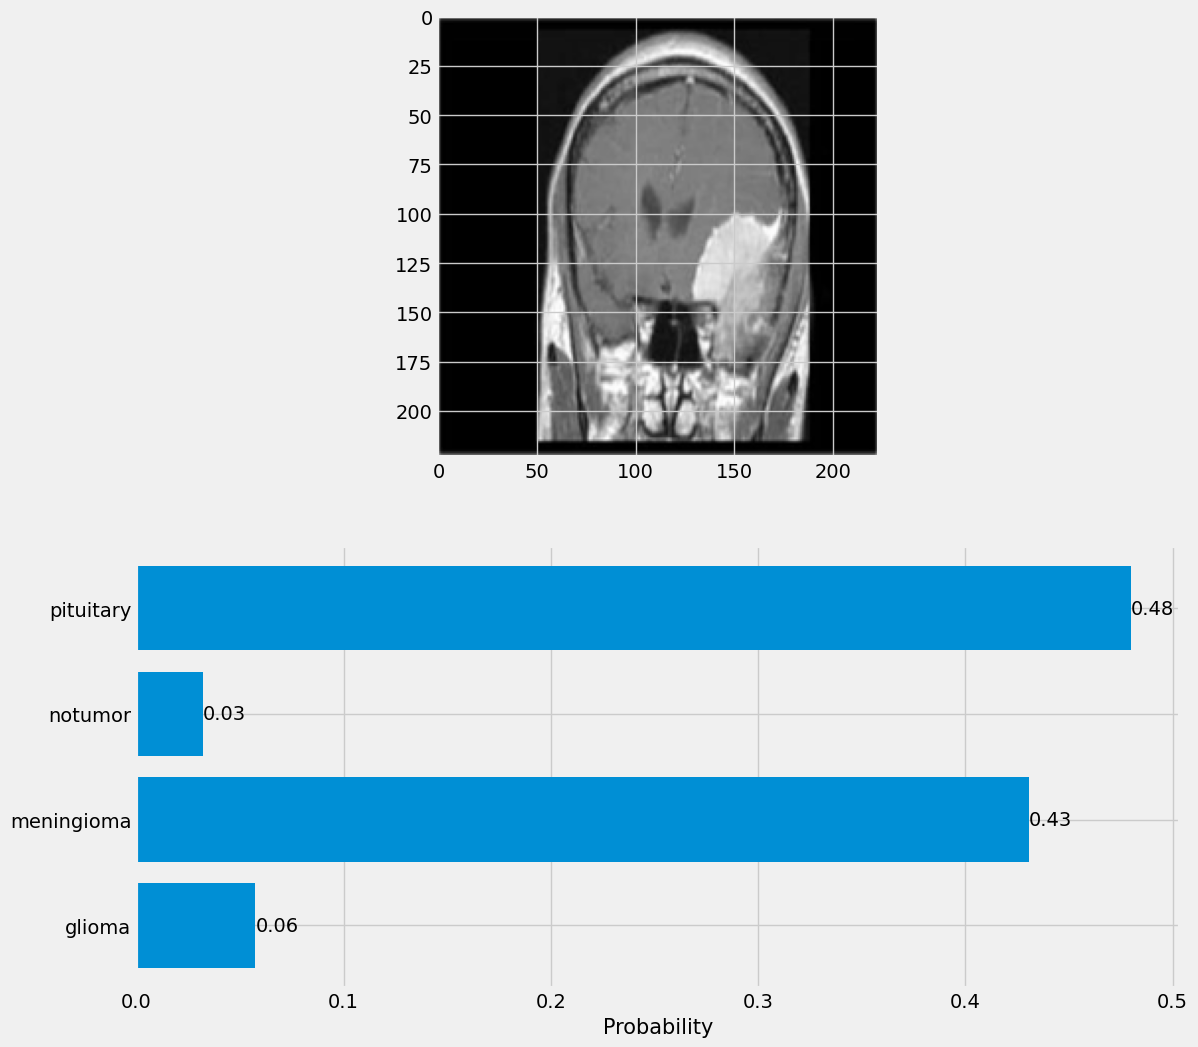

In [27]:
predict('/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/meningioma/Te-meTr_0000.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


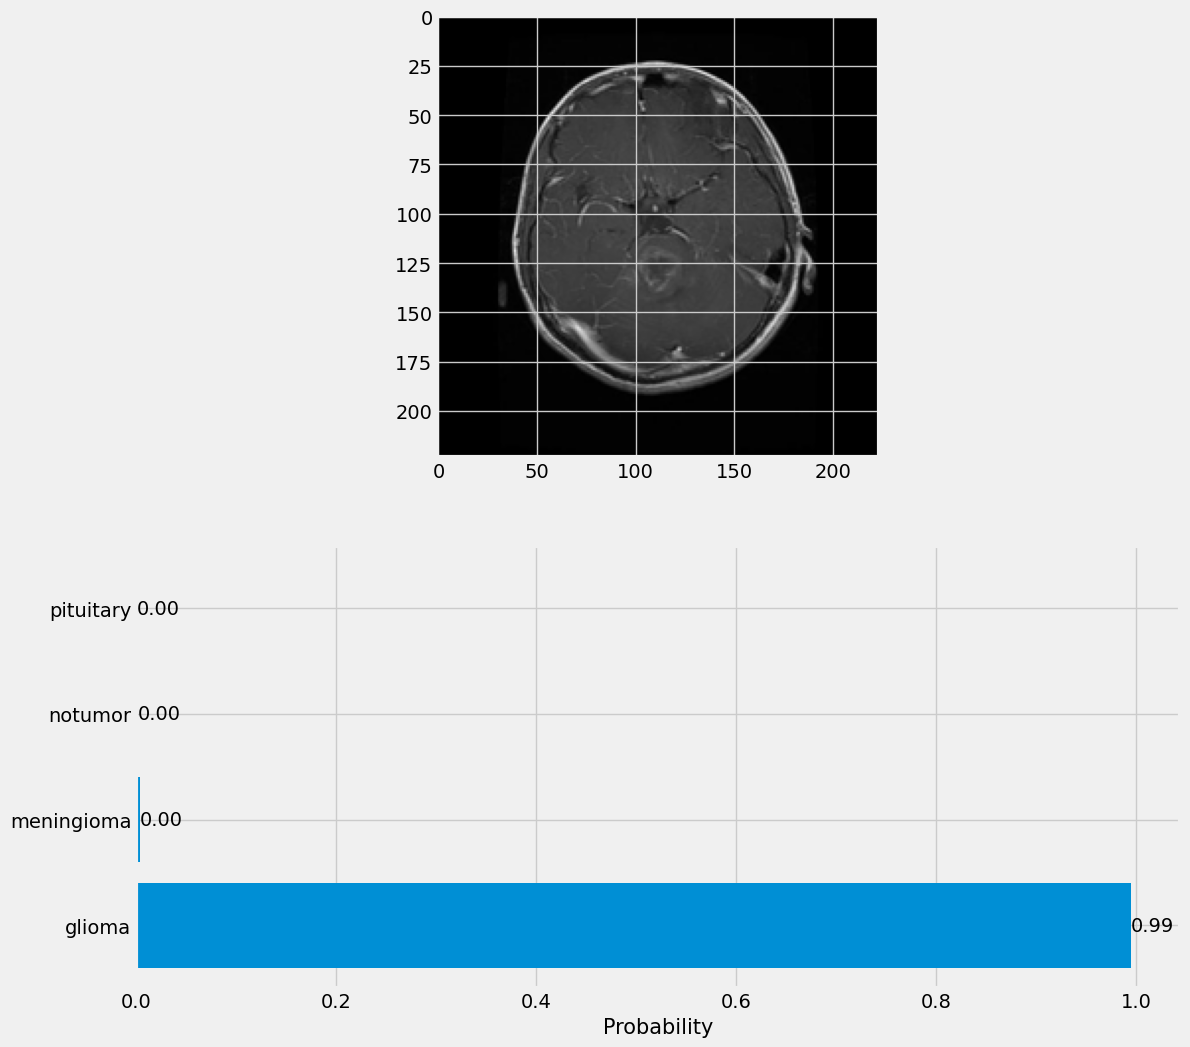

In [28]:
predict('/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/glioma/Te-glTr_0007.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


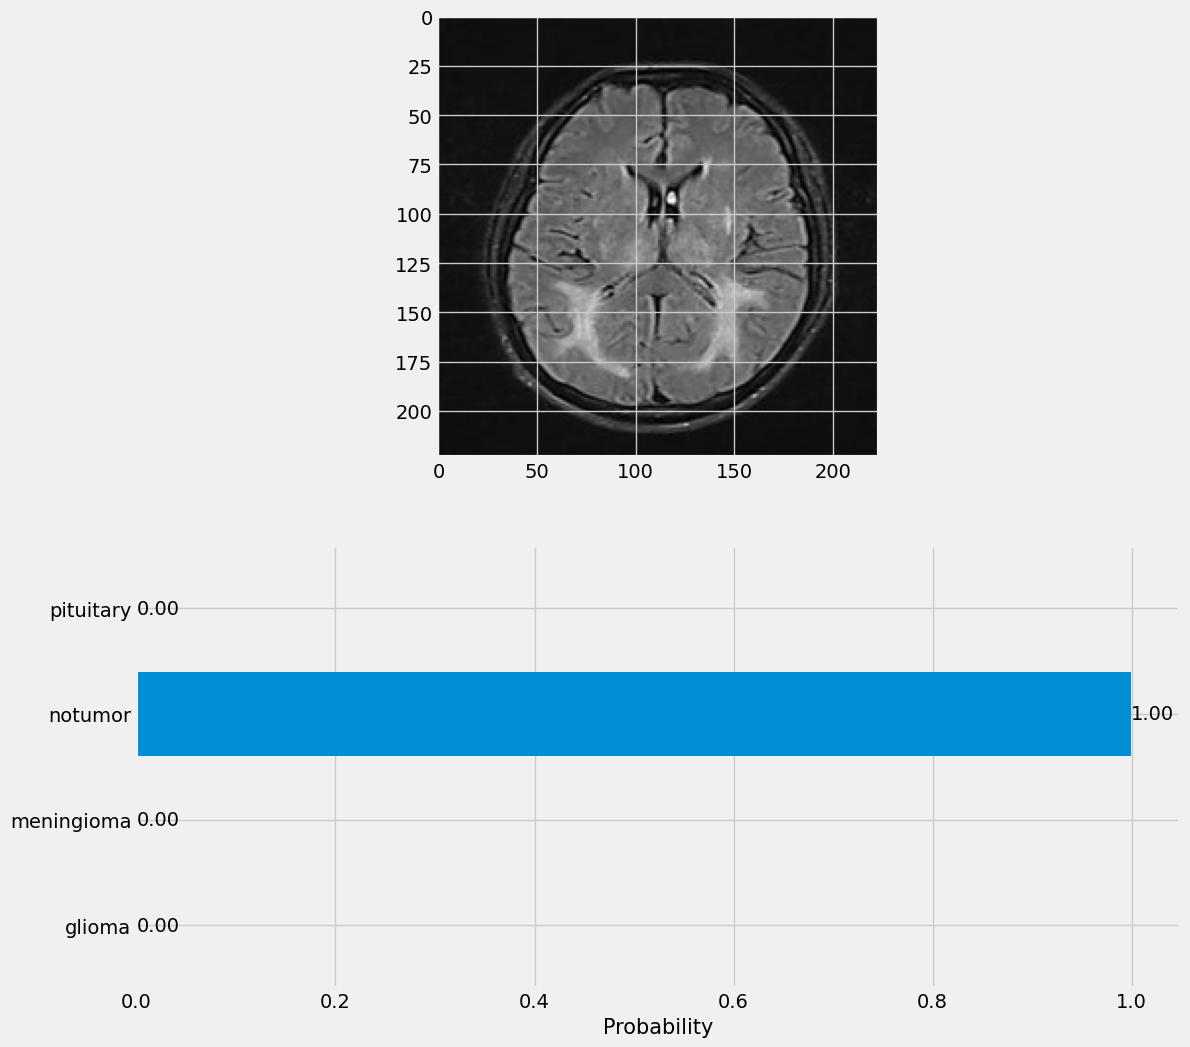

In [29]:
predict('/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/notumor/Te-noTr_0001.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


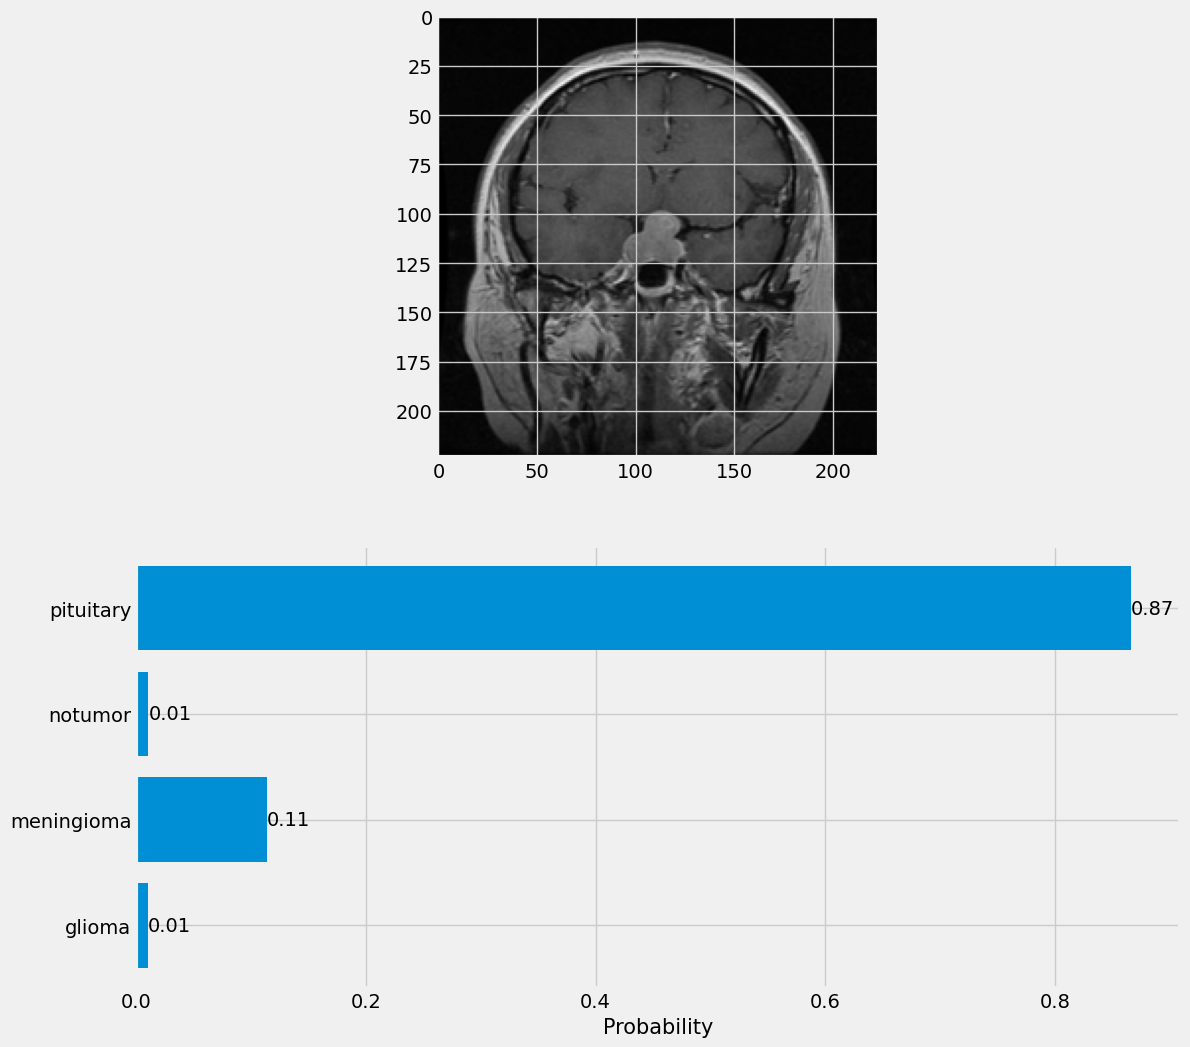

In [30]:
predict('/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/pituitary/Te-piTr_0001.jpg')